#### Step 1: Import libaries and packages

In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
from xgboost import XGBClassifier
SEED = 42

#### Step 2: Exploratory Data Analysis

In [2]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.shape

(569, 33)

In [4]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nColumns : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  569
Columns  :  33

Columns : 
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Missing values :   569

Unique values :  
 id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean         

In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

B    357
M    212
Name: diagnosis, dtype: int64


Text(0.5, 1.0, 'Diagnosis')

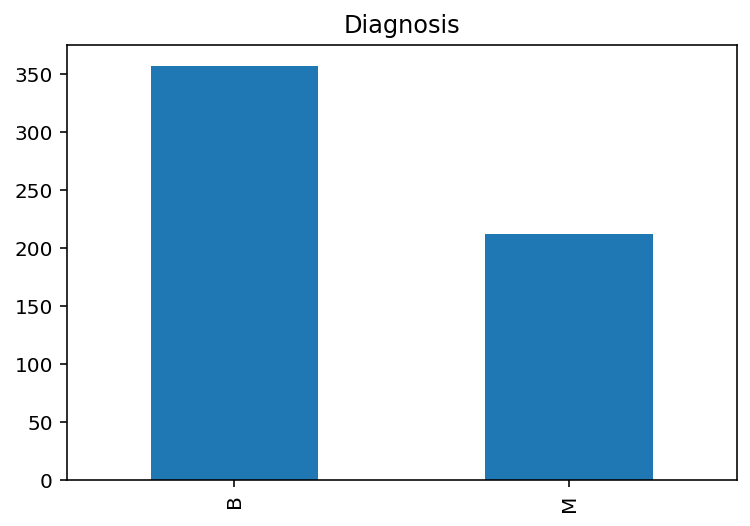

In [6]:
# Target class distribution is slightly imbalanced (see Appendix at the end of this notebook)
print(df['diagnosis'].value_counts())
df['diagnosis'].value_counts().plot('bar').set_title('Diagnosis')

In [7]:
# find columns which are of object types to consider if they need transformation or can be dropped
df1 = df.select_dtypes(['object'])
print (df1.head())

  diagnosis
0         M
1         M
2         M
3         M
4         M


In [8]:
# Label encoding to clean up of categorical data in feature "diagnosis"
categories_labels = {"diagnosis": {"B": 0, "M": 1}}

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [9]:
# Label encoding to clean up of categorical data in feature "diagnosis"
categories_labels = {"diagnosis": {"B": 0, "M": 1}}
# replace dataframe with labels for "diagnosis"                      
df.replace(categories_labels, inplace = True)

# test

# Ensure that all object type features are label encoded
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [10]:
# proportion of breast cancer patients
print ('\nProportion of Breast Cancer Patients : \n',round(df['diagnosis'].value_counts()[1] / df['diagnosis'].count(),2))
       


Proportion of Breast Cancer Patients : 
 0.37


In [11]:
# see all numerical columns
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [12]:
df.shape

(569, 33)

#### Step 3: Define X for features and Y for target for features selection

In [13]:
# define x as features (all columns except "diagnosis","id","Unnamed: 32") 
# define y ie target ""
X = df.drop(columns=["diagnosis","id","Unnamed: 32"]).astype(float)
y = df.loc[:, "diagnosis"].astype(int)

In [14]:
print(X.head)

<bound method NDFrame.head of      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0         17.990         10.38          122.80     1001.0          0.11840   
1         20.570         17.77          132.90     1326.0          0.08474   
2         19.690         21.25          130.00     1203.0          0.10960   
3         11.420         20.38           77.58      386.1          0.14250   
4         20.290         14.34          135.10     1297.0          0.10030   
5         12.450         15.70           82.57      477.1          0.12780   
6         18.250         19.98          119.60     1040.0          0.09463   
7         13.710         20.83           90.20      577.9          0.11890   
8         13.000         21.82           87.50      519.8          0.12730   
9         12.460         24.04           83.97      475.9          0.11860   
10        16.020         23.24          102.70      797.8          0.08206   
11        15.780         17.89    

In [15]:
print(y.head)

<bound method NDFrame.head of 0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     0
20     0
21     0
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
539    0
540    0
541    0
542    0
543    0
544    0
545    0
546    0
547    0
548    0
549    0
550    0
551    0
552    0
553    0
554    0
555    0
556    0
557    0
558    0
559    0
560    0
561    0
562    1
563    1
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int32>


In [16]:
print(X.shape, y.shape)

(569, 30) (569,)


Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (569, 30)
LASSO best alpha:  0.001
[('radius_worst', 0.48118912865246244), ('radius_se', 0.1308951251385537), ('concave points_mean', 0.08249670748630578), ('concavity_worst', 0.08017115633503137), ('concavity_mean', 0.07916634882561861), ('fractal_dimension_worst', 0.0692255418434438), ('concave points_worst', 0.05865674416800538), ('symmetry_worst', 0.04498520620313664), ('texture_worst', 0.04488332927060576), ('smoothness_se', 0.04353889493513244), ('concave points_se', 0.0381819503243029), ('texture_mean', 0.020295205532152638), ('smoothness_worst', 0.01955064027192022), ('symmetry_se', 0.0043063412150914195), ('radius_mean', 0.0), ('perimeter_mean', 0.0), ('smoothness_mean', -0.0), ('symmetry_mean', -0.0), ('perimeter_se', -0.0), ('perimeter_worst', 0.0), ('compactness_worst', -0.0), ('texture_se', -0.001886642174331476), ('area_mean', -0.005143478905260651), ('fractal_dimension_se', -0.0064190650943172075)

Text(0.5, 1.0, 'Top Features derived by LassoCV')

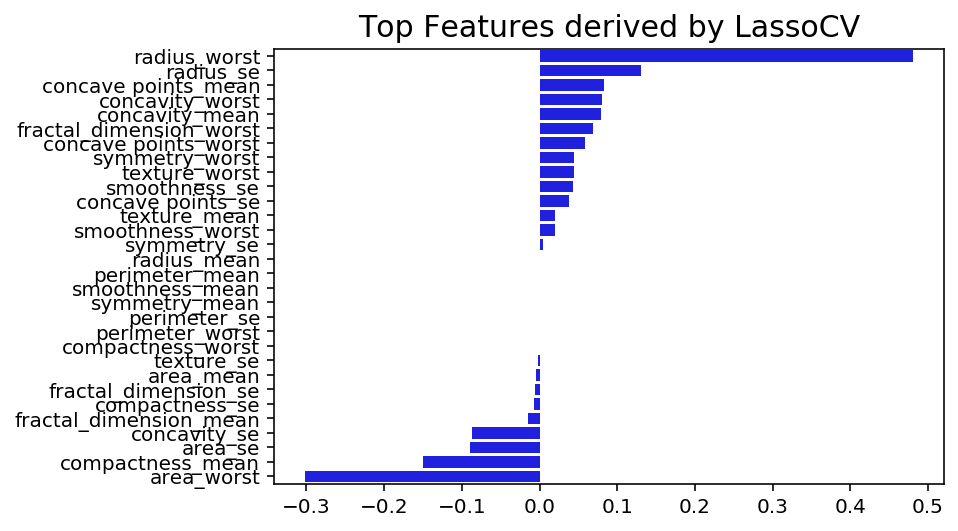

In [17]:
# to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )

# display all coefficients in the model with optimal alpha
zipped = list(zip(X.columns, lasso_model.coef_)) 
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

0.17467284202575684


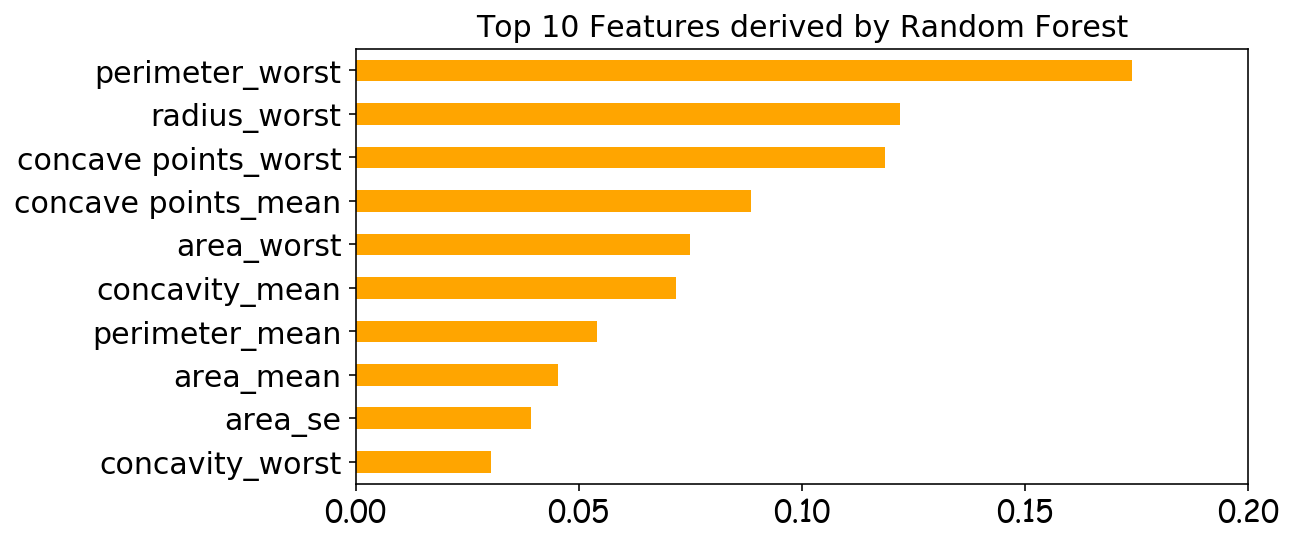

In [18]:
# Start time
time1 = time.time()

# Use random forest to find key features
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(X, y)

# Plot the top 10 features based on its importance
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10)   # choose top 10 features
   .plot(kind='barh', figsize=[8,4],color='orange')
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

ticks_x = np.linspace(0, 0.2,5)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=15, family='fantasy', color='black')
plt.yticks( size=15, color='black' )
plt.title('Top 10 Features derived by Random Forest', size=15)

# End time
time2 = time.time()
timetaken = time2 - time1
print (timetaken) 

In [19]:
# Using correlationg matrix to find features that are correlated with correlation of strength > absolute (0.5)
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>=0.6) # insert threshold
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

# Show features with correlation > absolute 0.5 to target
features = []
[features.append(i) for i in high_corr_var if 'diagnosis' in i]
features

[('diagnosis', 'radius_mean'),
 ('diagnosis', 'perimeter_mean'),
 ('diagnosis', 'area_mean'),
 ('diagnosis', 'concavity_mean'),
 ('diagnosis', 'concave points_mean'),
 ('diagnosis', 'radius_worst'),
 ('diagnosis', 'perimeter_worst'),
 ('diagnosis', 'area_worst'),
 ('diagnosis', 'concavity_worst'),
 ('diagnosis', 'concave points_worst')]

#### Step 4: Split data to 80:20 ratio using Stratify to maintain the same distribution, and perform Model Selection

In [20]:
# X = df.drop('diagnosis', axis=1)   # axis=0 for row, axis=1 for column
X = df.loc[:,['perimeter_worst','radius_worst','concave points_worst','concave points_mean','area_worst',
        'concavity_mean','perimeter_mean','area_mean','area_se','concavity_worst']]

y = df['diagnosis']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# # Data preprocessing, Scaling Numerical columns
# from sklearn.preprocessing import MinMaxScaler, StandardScaler   # not much difference in results
# # scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

X_train (455, 10)
y_train (455,)
X_test (114, 10)
y_test (114,)


In [21]:
df = X.join(y)

(11.5, -0.5)

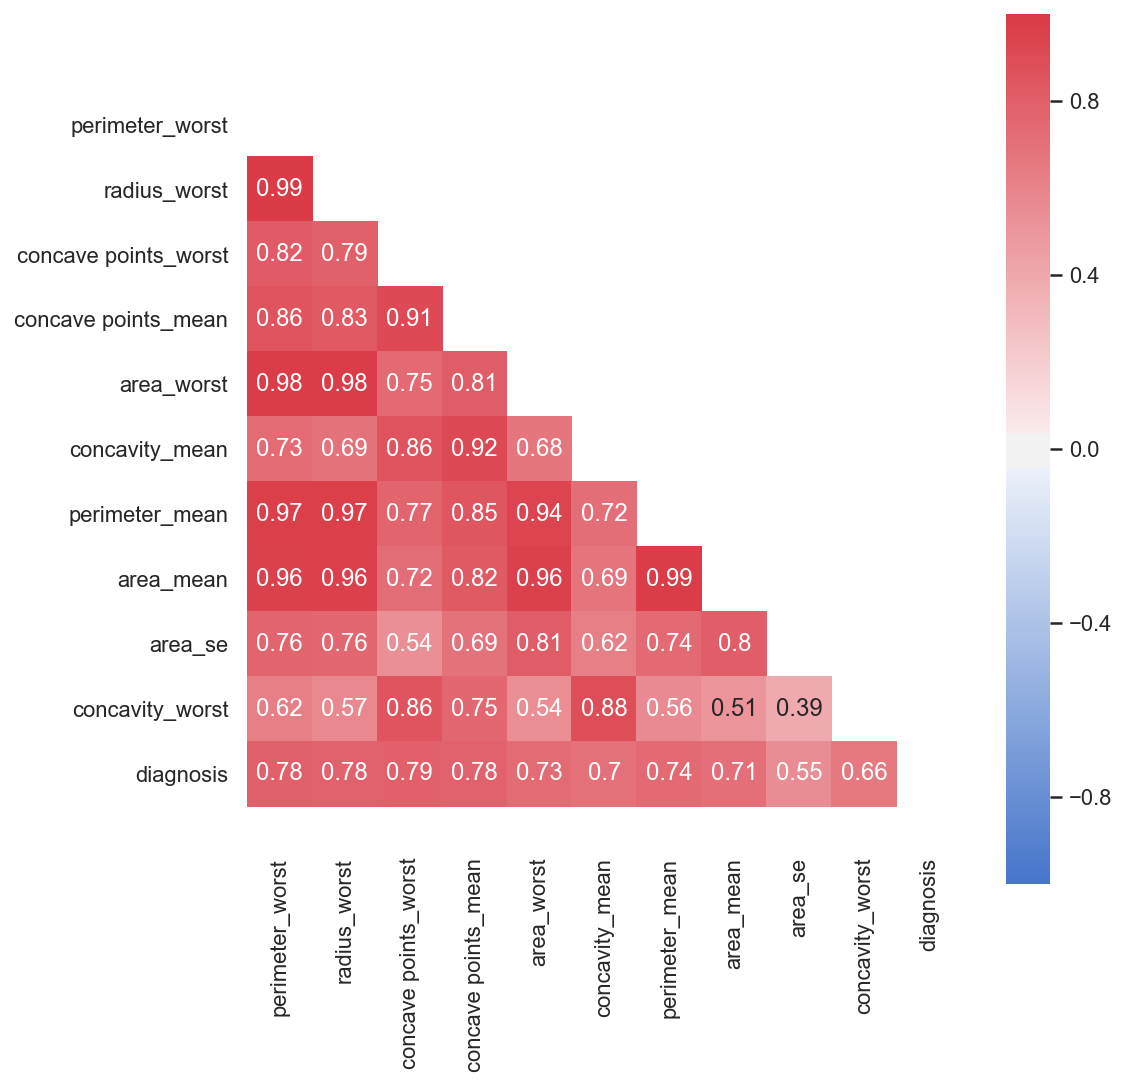

In [22]:
# Correlation Matrix Heatmap Visualization (should run this code again after removing outliers/zero values)
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(8,8))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

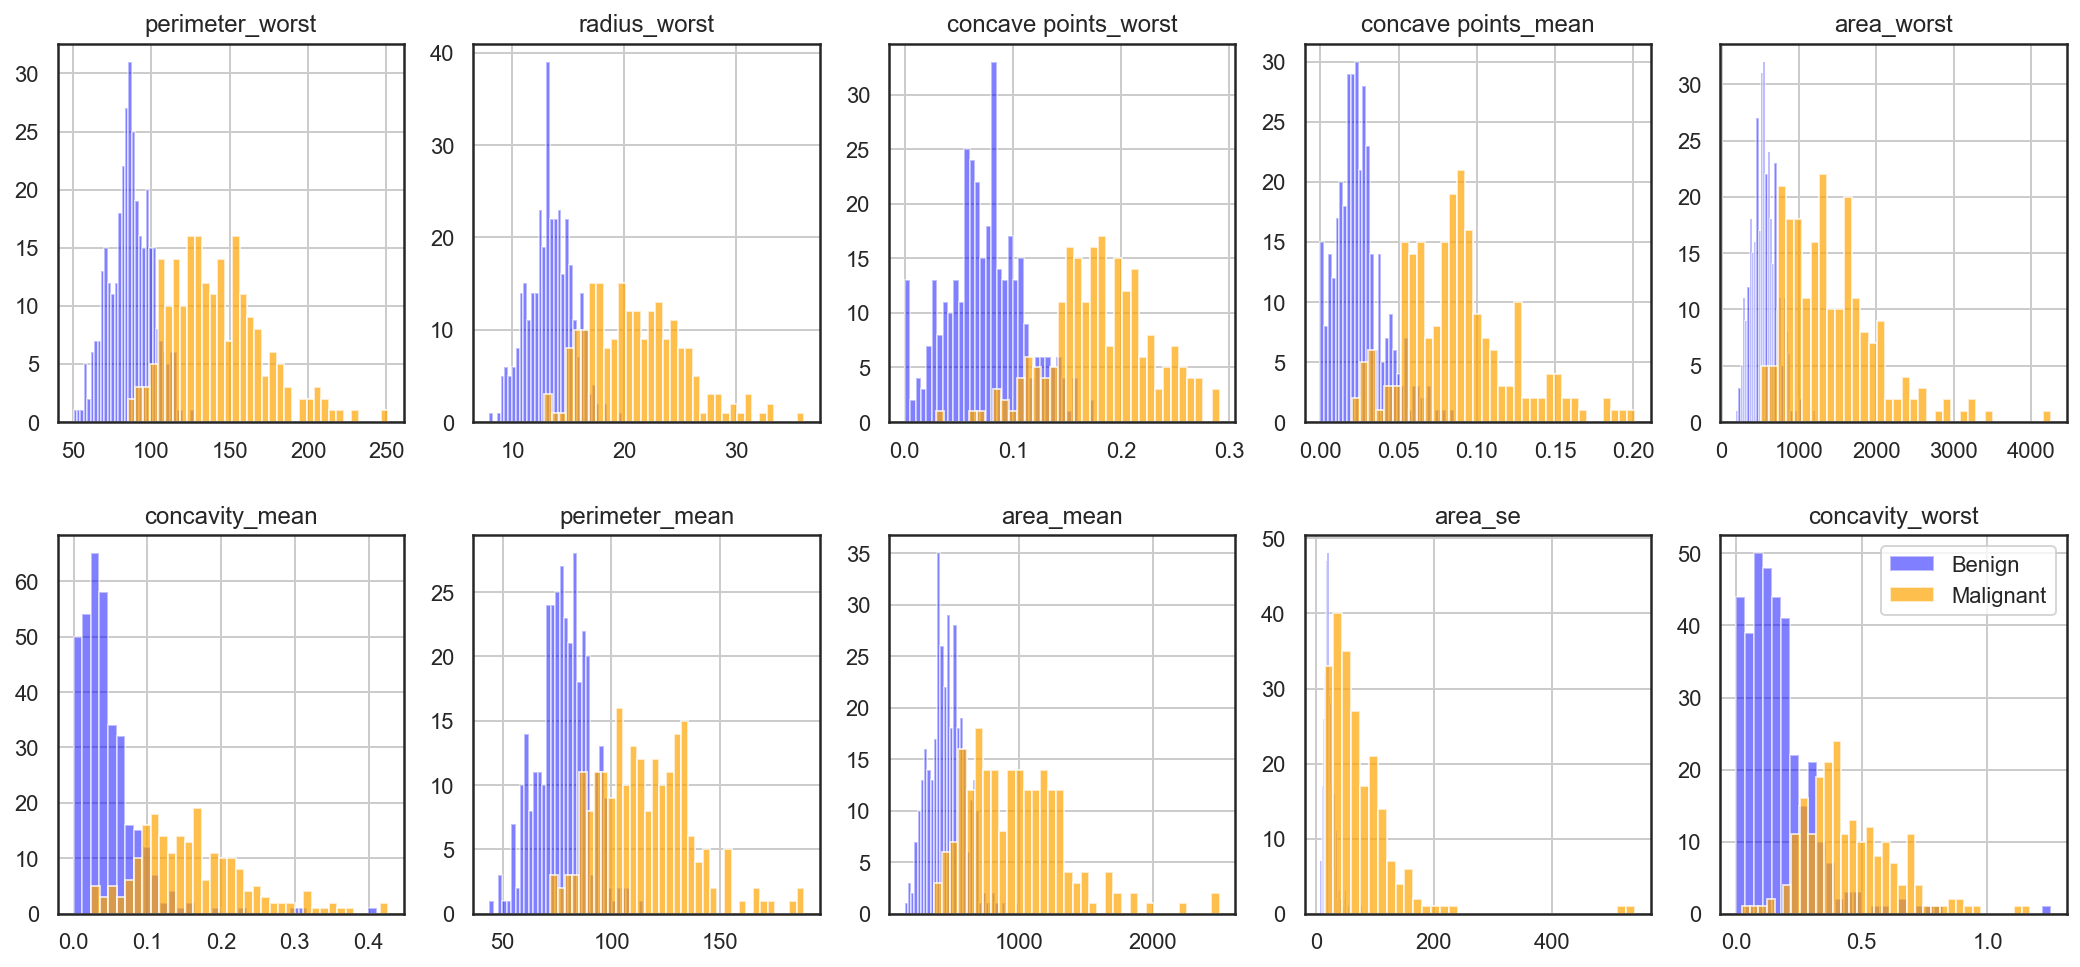

In [23]:
# To analyse feature-diagnosis distribution in visualisation
features = ['perimeter_worst','radius_worst','concave points_worst','concave points_mean','area_worst',
        'concavity_mean','perimeter_mean','area_mean','area_se','concavity_worst']

ROWS, COLS = 2, 5
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
#     df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  #show all, comment off below 2 lines
    df[df.diagnosis==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
    df[df.diagnosis==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
plt.legend(['Benign', 'Malignant'])
fig.subplots_adjust(hspace=0.3)

#### Redefine X and y

In [24]:
# X = df.drop('diagnosis', axis=1)   # axis=0 for row, axis=1 for column
X = df.loc[:,['radius_worst','concave points_worst','concave points_mean',
        'concavity_mean','area_se','concavity_worst']]

y = df['diagnosis']

In [25]:
## Baseline model performance evaluation
# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# to give model baseline report in dataframe 
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
xgb = XGBClassifier()
svc = SVC()
linearsvc = LinearSVC()

# to concat all models
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB'),
                       baseline_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB'),
                       baseline_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest'),
                       baseline_report(xgb, X_train, X_test, y_train, y_test, 'XGBoost'),
                       baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                       baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.938462,0.934046,0.900000,0.916209,0.982766,1.817837,0
1,BernoulliNB,0.626374,0.000000,0.000000,0.000000,0.519298,12.724812,0
2,MultinomialNB,0.909890,0.971903,0.782353,0.865896,0.962126,3.635661,0
3,LogisticRegression,0.942857,0.944248,0.900000,0.921187,0.984520,2.120802,0
4,KNN,0.920879,0.913200,0.870588,0.891163,0.953664,3.029724,0
5,DecisionTree,0.916484,0.875033,0.905882,0.891532,0.918421,2.726774,0
6,RandomForest,0.925275,0.939340,0.882353,0.898561,0.973323,1.211887,0
7,XGBoost,0.934066,0.912406,0.911765,0.911925,0.982456,1.211894,0
8,SVC,0.626374,0.000000,0.000000,0.000000,0.912487,12.724812,0
9,LinearSVC,0.903297,0.825926,0.923529,0.877184,0.966770,3.332696,0


#### Step 5: Optimise model: hyperparameter tuning

In [26]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

In [27]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1


print('\n"""""" MultinomialNB """"""')
mnb = MultinomialNB()
model3 = model_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
model3.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.9333,  0.100->0.9136,  0.200->0.9136,  0.300->0.9136,  0.400->0.9250,  0.500->0.9250,  0.600->0.9091,  0.700->0.9091,  0.800->0.8800,  0.900->0.8800,  1.000->0.8493,  
Looping decimal place 2
0.000->0.9333,  0.010->0.9524,  0.020->0.9524,  0.030->0.9524,  0.040->0.9398,  0.050->0.9398,  0.060->0.9136,  0.070->0.9136,  0.080->0.9136,  0.090->0.9136,  0.100->0.9136,  
Looping decimal place 3
0.000->0.9333,  0.001->0.9655,  0.002->0.9412,  0.003->0.9412,  0.004->0.9412,  0.005->0.9412,  0.006->0.9412,  0.007->0.9524,  0.008->0.9524,  0.009->0.9524,  0.010->0.9524,  0.011->0.9524,  0.012->0.9524,  0.013->0.9524,  0.014->0.9524,  0.015->0.9524,  0.016->0.9524,  0.017->0.9524,  0.018->0.9524,  0.019->0.9524,  0.020->0.9524,  optimal F1 score = 0.9655
optimal threshold = 0.001
GaussianNB accuracy score is
Training: 93.41%
Test set: 94.74%

Adjus

In [28]:
print('\n"""""" LogisticRegression """"""')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.8905, 0.8877, 0.8877, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8908, 0.8936, 0.8936, 0.8936, 0.8936, 0.8936, 0.8936, 0.8936, 0.8936, 0.8910, 0.8910, 0.8910, 0.8947, 0.8986, 0.8986, 0.8986, 0.8986, 0.8986, 0.8962, 0.8962, 0.8962, 0.8962, 0.8962, 0.8962, 0.8962, 0.8962, 0.8927, 0.8927, 0.8927, 0.8927, 0.8927, 0.8927, 0.8927, 0.8927, 0.8927, 0.8962, 0.8962, 0.8992, 0.8992, 0.8992, 0.8992, 0.8992, 0.8992, 0.8992, 0.9029, 0.9029, 0.9029, 0.9029, 0.9029, 0.9059, 0.9059, 0.9059, 0.9059, 0.9059, 0.9087, 0.9087, 0.9087, 0.9087, 0.9087, 0.9083, 0.9111, 0.9087, 0.9087, 0.9087, 0.9087, 0.9087, 0.9087, 0.9087, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9111, 0.9083, 0.9111, 

In [29]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, X_train, X_test, y_train, y_test, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.9018, 0.8859, 0.9033, 0.9076, 0.9118, 0.8953, 0.9150, 0.8952, 0.9056, 0.8945, 0.8949, 0.8911, 0.8911, 0.8973, 0.8942, 0.8973, 0.8942, 0.8872, 0.8872, 0.8841, optimal cv F1 score = 0.9150
optimal value of K = 7

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.8723,  0.100->0.8723,  0.200->0.9268,  0.300->0.8831,  0.400->0.8831,  0.500->0.8684,  0.600->0.8649,  0.700->0.8649,  0.800->0.8169,  0.900->0.7273,  1.000->0.7273,  
Looping decimal place 2
0.100->0.8723,  0.110->0.8723,  0.120->0.8723,  0.130->0.8723,  0.140->0.8723,  0.150->0.9268,  0.160->0.9268,  0.170->0.9268,  0.180->0.9268,  0.190->0.9268,  0.200->0.9268,  0.210->0.9268,  0.220->0.9268,  0.230->0.9268,  0.240->0.9268,  0.250->0.9268,  0.260->0.9268,  0.270->0.9268,  0.280->0.9268,  0.290->0.8831,  0.300->0.8831,  
Loo

In [30]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree')
model6.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.8972, 0.8910, 0.8964, 0.8895, 0.8972, 0.8906, 0.8753, 0.8792, 0.8900, optimal F1 score = 0.8972
optimal max_depth = 6

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.7723,  0.100->0.9024,  0.200->0.9024,  0.300->0.9024,  0.400->0.9024,  0.500->0.9136,  0.600->0.9136,  0.700->0.9136,  0.800->0.9136,  0.900->0.9136,  1.000->0.9136,  
Looping decimal place 2
0.400->0.9024,  0.410->0.9024,  0.420->0.9024,  0.430->0.9136,  0.440->0.9136,  0.450->0.9136,  0.460->0.9136,  0.470->0.9136,  0.480->0.9136,  0.490->0.9136,  0.500->0.9136,  0.510->0.9136,  0.520->0.9136,  0.530->0.9136,  0.540->0.9136,  0.550->0.9136,  0.560->0.9136,  0.570->0.9136,  0.580->0.9136,  0.590->0.9136,  0.600->0.9136,  
Looping decimal place 3
0.420->0.9024,  0.421->0.9024,  0.422->0.9024,  0.423->0.9

In [31]:
print('\n"""""" RandomForestClassifier """"""')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest')
model7.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" RandomForestClassifier """"""

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.9194, 150->0.9199, 200->0.9165, 250->0.9199, 300->0.9199, 350->0.9199, 400->0.9199, 450->0.9224, 500->0.9175, optimal F1 score = 0.9224
optimal n_estimators = 450

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.6774,  0.100->0.8936,  0.200->0.9091,  0.300->0.9176,  0.400->0.9398,  0.500->0.9367,  0.600->0.9367,  0.700->0.9367,  0.800->0.8800,  0.900->0.7826,  1.000->0.6667,  
Looping decimal place 2
0.300->0.9176,  0.310->0.9286,  0.320->0.9286,  0.330->0.9286,  0.340->0.9286,  0.350->0.9286,  0.360->0.9286,  0.370->0.9286,  0.380->0.9286,  0.390->0.9398,  0.400->0.9398,  0.410->0.9398,  0.420->0.9512,  0.430->0.9512,  0.440->0.9512,  0.450->0.9512,  0.460->0.9630,  0.470->0.9630,  0.480->0.9500,  0.490->0.9500,  0.500->0.9367,  
Looping decimal place 3
0.

In [32]:
print('\n"""""" XGBoostClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in XGBoost, vary 2 to 50, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    xgb = XGBClassifier(max_depth=d)
    cvs = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

xgb = XGBClassifier(max_depth=optimal_d)
model8 = model_report(xgb, X_train, X_test, y_train, y_test, 'XGBoost')
model8.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" XGBoostClassifier """"""

Search for optimal max_depth in XGBoost, vary 2 to 50, using KFold(5) Cross Validation on train data
0.9231, 0.9191, 0.9164, 0.9221, 0.9191, 0.9157, 0.9157, 0.9157, 0.9157, optimal F1 score = 0.9231
optimal max_depth = 2

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5385,  0.100->0.9438,  0.200->0.9398,  0.300->0.9512,  0.400->0.9512,  0.500->0.9500,  0.600->0.9500,  0.700->0.9367,  0.800->0.9367,  0.900->0.8800,  1.000->0.0000,  
Looping decimal place 2
0.200->0.9398,  0.210->0.9398,  0.220->0.9398,  0.230->0.9398,  0.240->0.9398,  0.250->0.9398,  0.260->0.9512,  0.270->0.9512,  0.280->0.9512,  0.290->0.9512,  0.300->0.9512,  0.310->0.9512,  0.320->0.9512,  0.330->0.9512,  0.340->0.9512,  0.350->0.9512,  0.360->0.9512,  0.370->0.9512,  0.380->0.9512,  0.390->0.9512,  0.400->0.9512,  
Looping decimal place 3
0.250->0.9398,  0.251->0.9398,  0.252->0.9512,  0.253->0.9512,  0.25

In [33]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model9 = model_report(svc, X_train, X_test, y_train, y_test, 'SVC')
model9.timetaken[0] = time.time() - time1


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5385,  0.100->0.8400,  0.200->0.8837,  0.300->0.8780,  0.400->0.8684,  0.500->0.8684,  0.600->0.8800,  0.700->0.8169,  0.800->0.7826,  0.900->0.7273,  1.000->0.5517,  
Looping decimal place 2
0.100->0.8400,  0.110->0.8542,  0.120->0.8632,  0.130->0.8632,  0.140->0.8723,  0.150->0.8817,  0.160->0.8791,  0.170->0.8989,  0.180->0.8966,  0.190->0.8966,  0.200->0.8837,  0.210->0.8837,  0.220->0.8837,  0.230->0.8941,  0.240->0.8810,  0.250->0.8810,  0.260->0.8810,  0.270->0.8810,  0.280->0.8916,  0.290->0.8780,  0.300->0.8780,  
Looping decimal place 3
0.160->0.8791,  0.161->0.8791,  0.162->0.8791,  0.163->0.8889,  0.164->0.8889,  0.165->0.8989,  0.166->0.8989,  0.167->0.8989,  0.168->0.8989,  0.169->0.8989,  0.170->0.8989,  0.171->0.8989,  0.172->0.8989,  0.173->0.9091,  0.174->0.8966,  0.175->0.8966,  0.176->0.8966,  0.177->0.8966,  0.178->0.8966,  

In [34]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
accuracy      = linearsvc.score(X_test, y_test)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = linearsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1score      = f1_score(y_test, y_pred) 
rocauc       = roc_auc_score(y_test, y_pred)
logloss      = log_loss(y_test, y_pred)
print('LinearSVC AUC: {:.4f}'.format(rocauc))
print('LinearSVC Log-loss: {:.4f}'.format(logloss))

model10 = pd.DataFrame({'model'        : ['LinearSVC'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 51.87%
Test set: 54.39%
              precision    recall  f1-score   support

           0       1.00      0.28      0.43        72
           1       0.45      1.00      0.62        42

    accuracy                           0.54       114
   macro avg       0.72      0.64      0.53       114
weighted avg       0.80      0.54      0.50       114

LinearSVC confusion matrix: 
 [[20 52]
 [ 0 42]]
LinearSVC AUC: 0.6389
LinearSVC Log-loss: 15.7549


#### Step 6: Compiling the results of all tuned models

In [35]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8,model9,model10],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.947368,0.933333,1.000000,0.965517,0.995701,0.221438,0.000000
1,BernoulliNB,0.631579,0.375000,1.000000,0.545455,0.513889,0.651855,0.000000
2,MultinomialNB,0.894737,0.971429,0.809524,0.883117,0.959987,1.263286,0.000000
3,LogisticRegression,0.964912,1.000000,0.976190,0.987952,0.998347,0.093031,4.000000
4,KNN,0.912281,0.950000,0.904762,0.926829,0.977348,0.448647,0.000000
5,DecisionTree,0.938596,0.948718,0.880952,0.913580,0.934524,1.583665,0.000000
6,RandomForest,0.956140,1.000000,0.928571,0.962963,0.992725,0.113897,14.000000
7,XGBoost,0.964912,0.975000,0.928571,0.951220,0.996693,0.092336,2.000000
8,SVC,0.912281,0.869565,0.952381,0.909091,0.981481,0.197486,0.000000
9,LinearSVC,0.543860,0.446809,1.000000,0.617647,0.638889,15.754894,0.029953


In [36]:
df_models   # compare with baseline results before tuning

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.938462,0.934046,0.900000,0.916209,0.982766,1.817837,0
1,BernoulliNB,0.626374,0.000000,0.000000,0.000000,0.519298,12.724812,0
2,MultinomialNB,0.909890,0.971903,0.782353,0.865896,0.962126,3.635661,0
3,LogisticRegression,0.942857,0.944248,0.900000,0.921187,0.984520,2.120802,0
4,KNN,0.920879,0.913200,0.870588,0.891163,0.953664,3.029724,0
5,DecisionTree,0.916484,0.875033,0.905882,0.891532,0.918421,2.726774,0
6,RandomForest,0.925275,0.939340,0.882353,0.898561,0.973323,1.211887,0
7,XGBoost,0.934066,0.912406,0.911765,0.911925,0.982456,1.211894,0
8,SVC,0.626374,0.000000,0.000000,0.000000,0.912487,12.724812,0
9,LinearSVC,0.903297,0.825926,0.923529,0.877184,0.966770,3.332696,0


In [37]:
# initialise an empty df for comparison: 1 = improved, 0 = no improvement
df1 = pd.DataFrame({'model': [0]*10,'accuracy': [0]*10,'precision': [0]*10,'recall': [0]*10,'f1score': [0]*10,'rocauc': [0]*10,'logloss': [0]*10,'timetaken': [0]*10})
df1.model = df_models.model
for i in range(1,6):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] > df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
for i in range(6,8):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] < df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
df1   # Note: F1-Score has improved for all models after tuning the threshold and other hyperparameters

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,1,0,1,1,1,1,0
1,BernoulliNB,1,1,1,1,0,1,0
2,MultinomialNB,0,0,1,1,0,1,0
3,LogisticRegression,1,1,1,1,1,1,0
4,KNN,0,1,1,1,1,1,0
5,DecisionTree,1,1,0,1,1,1,0
6,RandomForest,1,1,1,1,1,1,0
7,XGBoost,1,1,1,1,1,1,0
8,SVC,1,1,1,1,1,1,0
9,LinearSVC,0,0,0,0,0,0,0


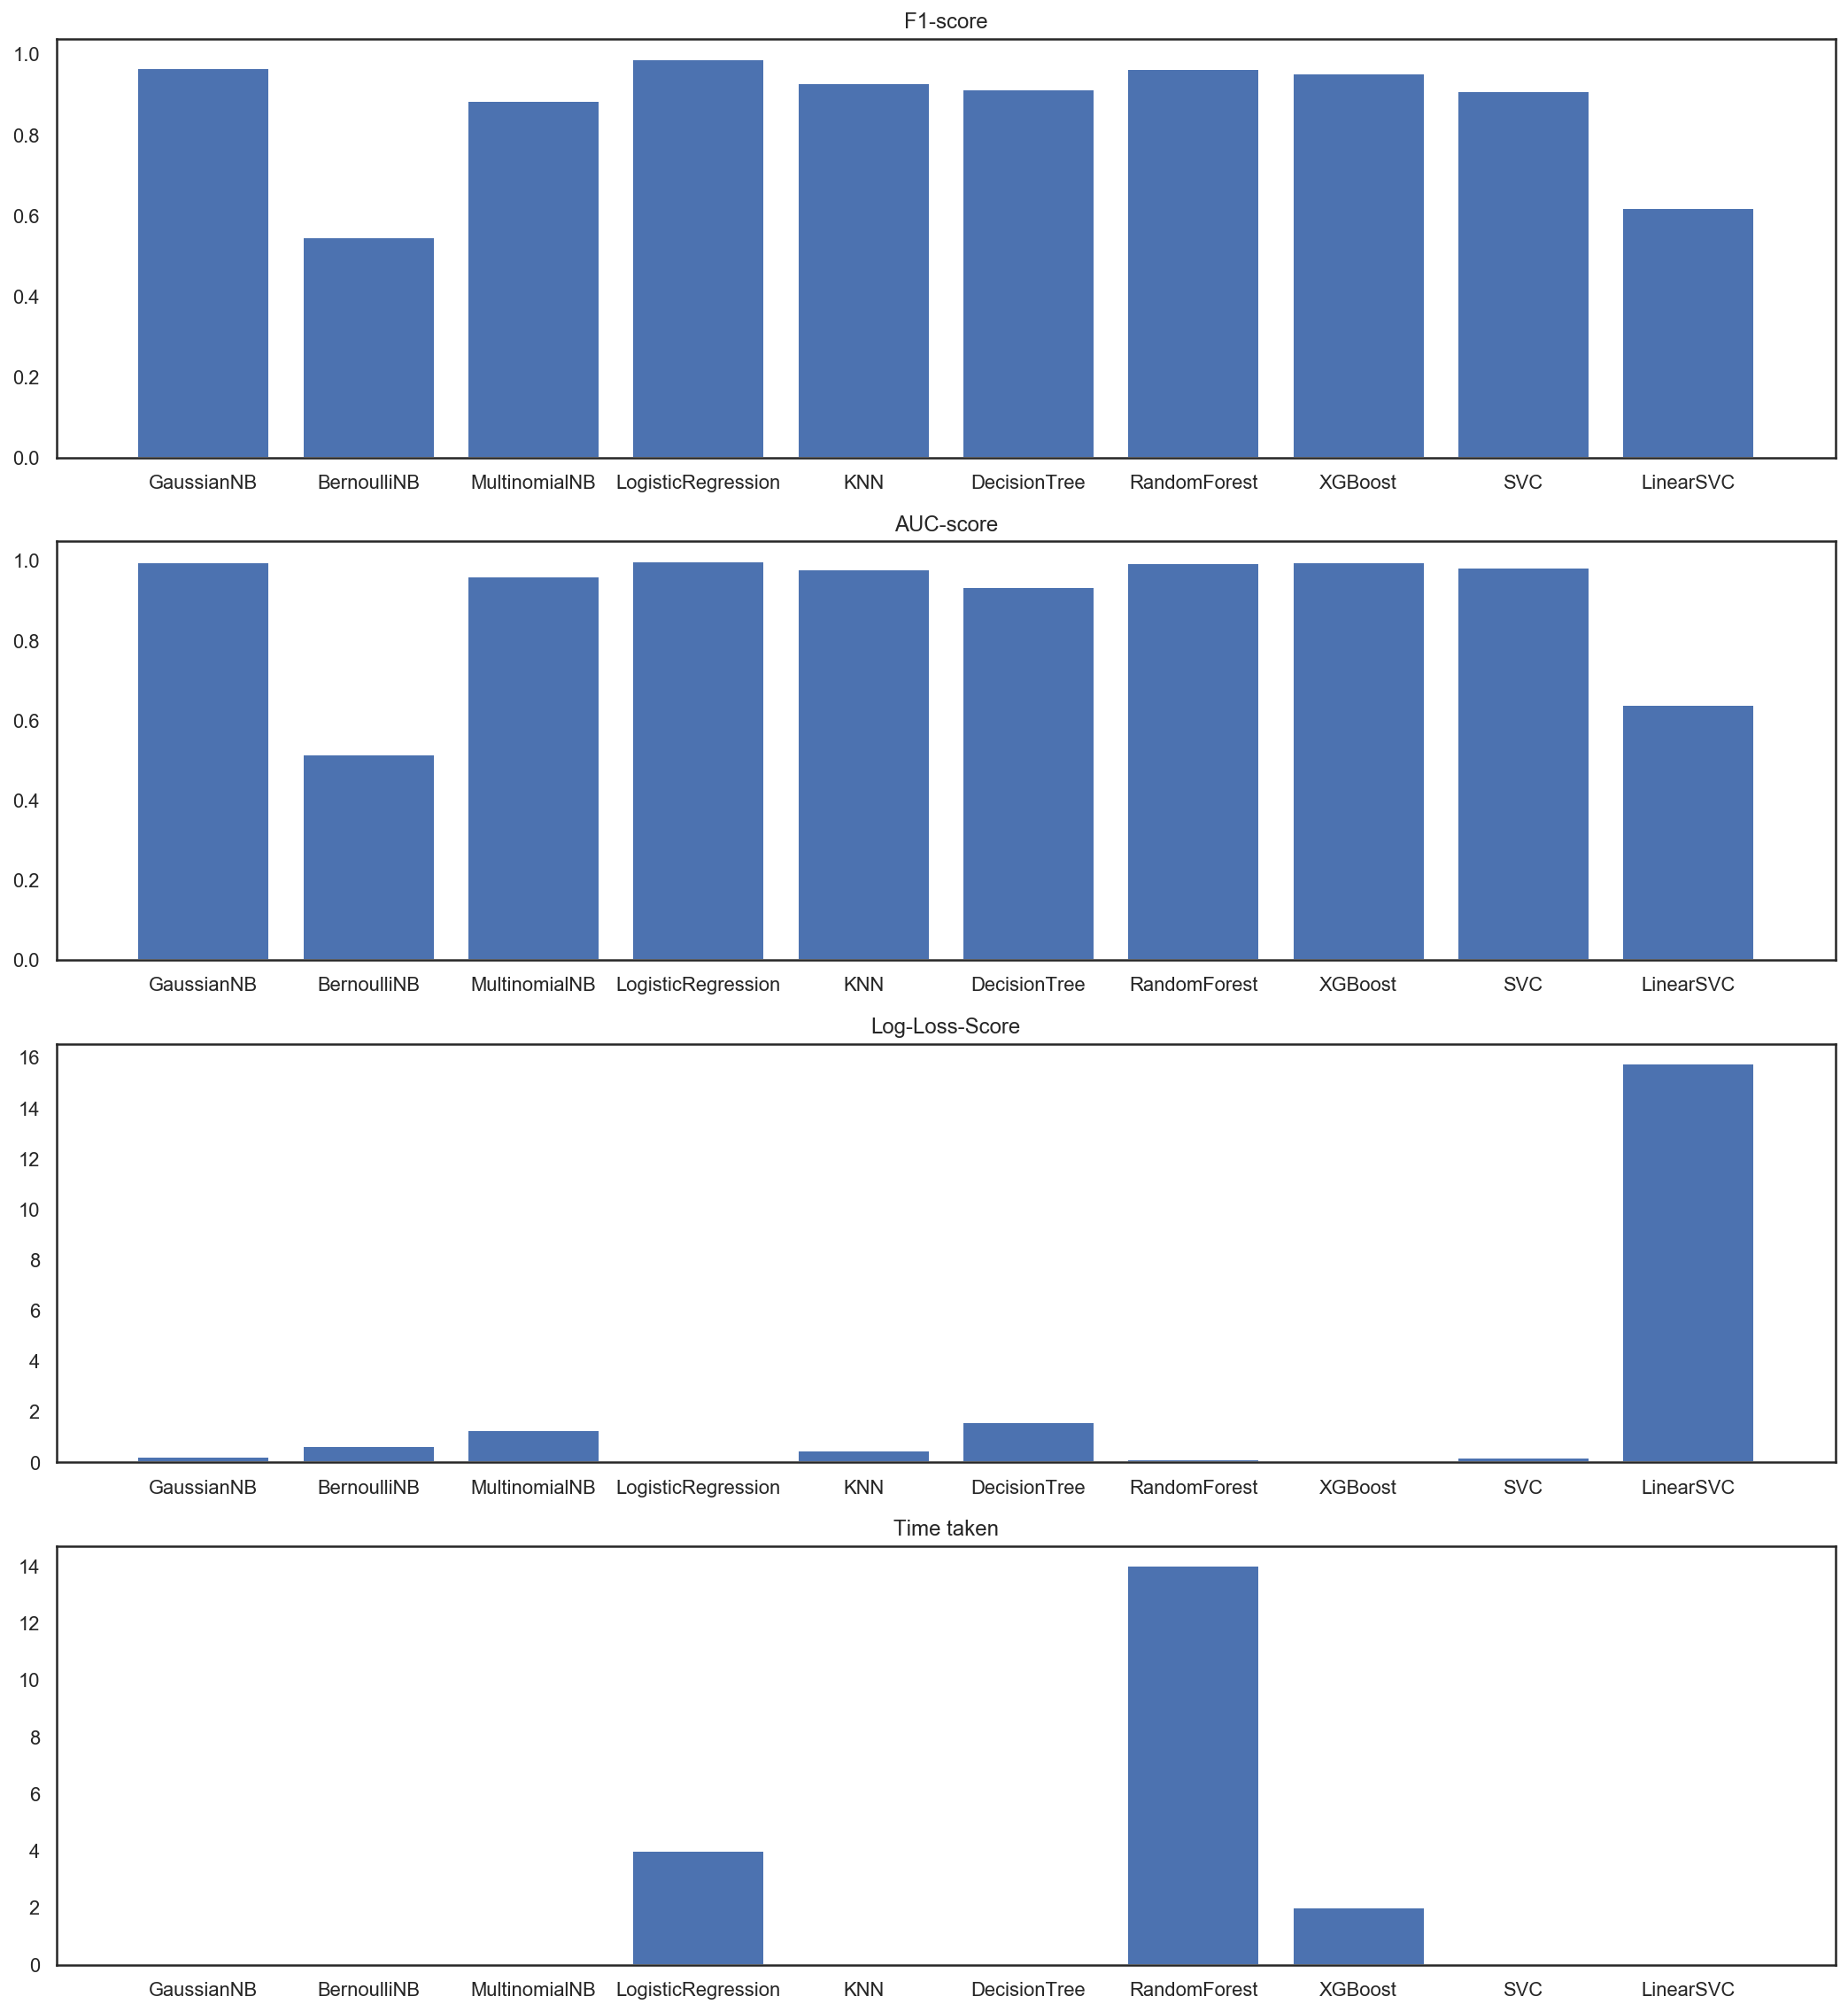

In [38]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

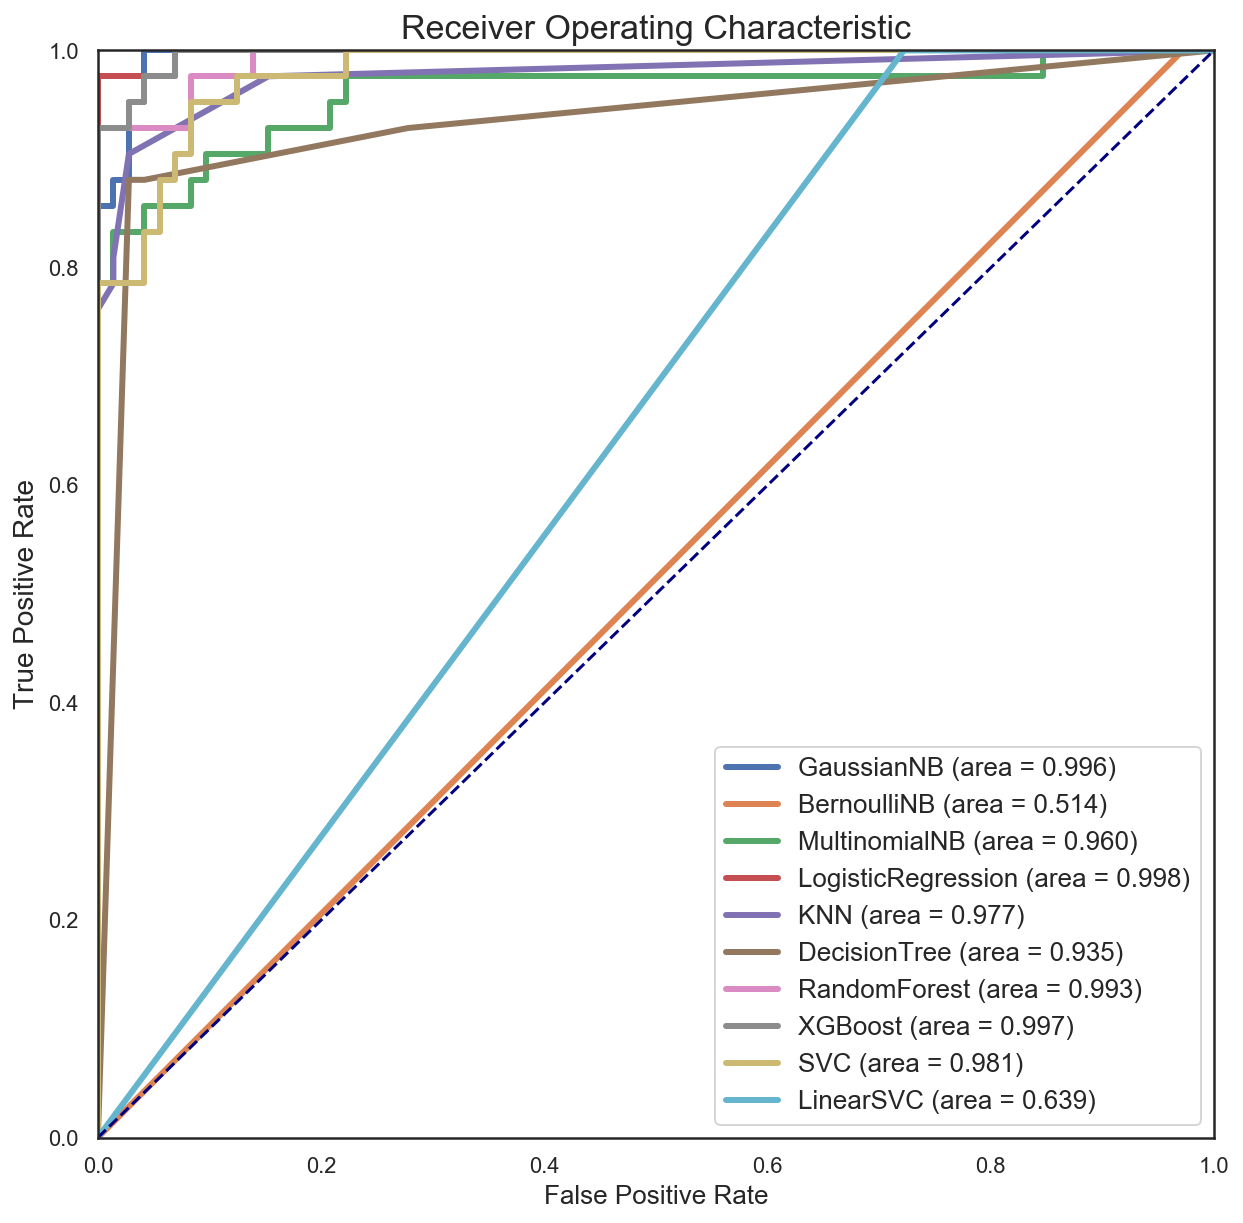

In [39]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, mnb, logit, knn, decisiontree, randomforest, xgb, svc, linearsvc]

for i in range(9):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = linearsvc.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

#### Step 7: Best Model

In [40]:
# see how model confusion matrix varies with threshold
bestmodel = logit

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['benign', 'malignant'],
           yticklabels=['benign', 'malignant']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…